In [1]:
# This notebook loads tracks from a stack, finds where the tracks cross the rows,
# crops out images before and after the crossing. It saves the images in a girder
# lightbox in the series folder.

from __future__ import division, print_function
from ipywidgets import interact, interactive, fixed, interact_manual    
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
from scipy import ndimage
from IPython.core.debugger import set_trace
import cv2
import sys
from pprint import pprint
from random import randint
from nuclei.foci import *
import nuclei.girder as g
import nuclei.girder.time_lapse_data as reader

plt.rcParams['image.cmap'] = 'gist_earth'
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)


# input parameters
czi_folder_id = "5ada43f41fbb9005ff7260eb"
series_idx = 12




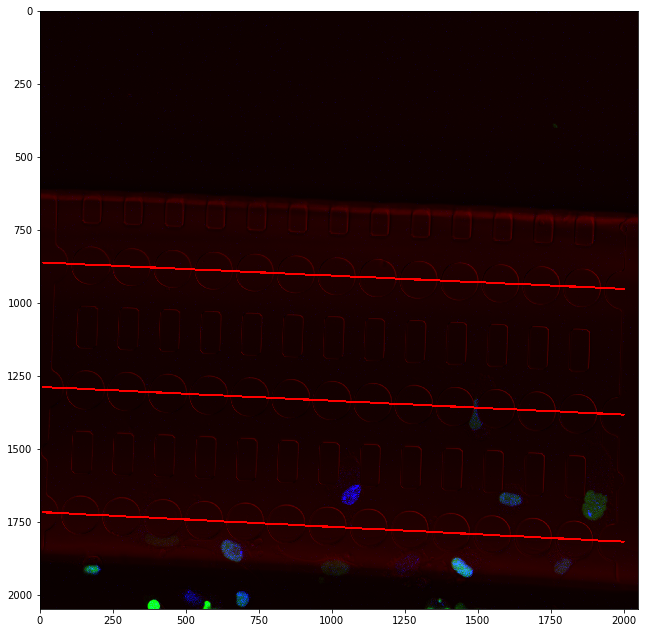

In [2]:
# This block sets up the reader of a czi folder.
# it then detects rows in the brightfield channel of an image.

# Setup the reader.
source = reader.time_lapse_data()
source.load(czi_folder_id) 
num_series = source.get_number_of_series()
num_time_steps = source.get_series_length(series_idx)
im, item_obj = source.get_image(series_idx,0)
series_folder = source.get_series_folder(series_idx)

# detect rows of circles.
rows = compute_rows(im)

# draw the row as a santity check
for row in rows:
    cv2.line(im,(10,int(10*row[0]+row[1])),(2000,int(2000*row[0]+row[1])),(255,0,0),5)

plt.imshow(im)



In [3]:
# Load the tracks
# First get the stack id from the source.
stack = source.get_series_stack(series_idx)

# Get the tracks from the stack item
annotation = g.Annotation("tracks")
annotation.LoadFromItem(stack['_id'])

print(annotation)

tracks = annotation.annot_obj['elements']

In [4]:
# find the crossings of the tracks.

def cross_line(track, rowindex):
    if track['type'] == 'polyline':
        points = track['points']
        point = points[0]
        if is_above_line(int(rows[rowindex][0]),int(rows[rowindex][1]),point[0],point[1]):
            return None
        for point in points:    
            if is_above_line(int(rows[rowindex][0]),int(rows[rowindex][1]),point[0],point[1]+30):
                return point

crossings = []
for track in tracks:
    #calulate the time for which the track crosses the row of circular barriers
    for rowindex in range(3):
        point = cross_line(track,rowindex)
        if point != None:
            crossings.append([track,point[2],rowindex+1])
    

        
print(len(crossings))
        
        

13


In [5]:

# For each crossing, from 10 frame before and 10 frame after.
# the frame number is in the z index of the track point.
for crossing in crossings:
    end_time = crossing[1] + 10
    images = []
    track = crossing[0]
    
    for i in range(20):
        x = -1
        if track['type'] == 'polyline':
            points = track['points']
            for point in points:
                if point[2] == end_time-i:
                    x,y,z = point
        if x != -1:
            im, item_obj = source.get_image(series_idx, end_time-i)
            im = im[int(y)-64:int(y)+64, int(x)-64:int(x)+64, ...]
            images.append(im)
        else:
            blank_image = np.zeros((128,128,3), np.uint8)
            images.append(blank_image)



    images.reverse()

    #fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
    #ax[0][0].imshow(images[0], aspect="auto")
    #ax[0][1].imshow(images[1], aspect="auto")
    #ax[0][2].imshow(images[2], aspect="auto")
    #ax[0][3].imshow(images[3], aspect="auto")
    #ax[0][4].imshow(images[4], aspect="auto")
    #ax[1][0].imshow(images[5], aspect="auto")
    #ax[1][1].imshow(images[6], aspect="auto")
    #ax[1][2].imshow(images[7], aspect="auto")
    #ax[1][3].imshow(images[8], aspect="auto")
    #ax[1][4].imshow(images[9], aspect="auto")
    #ax[2][0].imshow(images[10], aspect="auto")
    #ax[2][1].imshow(images[11], aspect="auto")
    #ax[2][2].imshow(images[12], aspect="auto")
    #ax[2][3].imshow(images[13], aspect="auto")
    #ax[2][4].imshow(images[14], aspect="auto")
    #ax[3][0].imshow(images[15], aspect="auto")
    #ax[3][1].imshow(images[16], aspect="auto")
    #ax[3][2].imshow(images[17], aspect="auto")
    #ax[3][3].imshow(images[18], aspect="auto")
    #ax[3][4].imshow(images[19], aspect="auto")
    
    cross_time = crossing[1]
    cross_row = crossing[2]
    cross_x = x
    g.upload_images(images, 'cross_%d_%d_%d'%(cross_time, cross_row, x), series_folder['_id'])

    



ValueError: 'arr' does not have a suitable array shape for any mode.